# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Valeria Oliva Hernandez

**Professor**: Pablo Camarillo Ramirez

# Introduction

La Cruz Roja Mexicana enfrenta el desafío de gestionar grandes volúmenes de datos provenientes de sus más de 1,200 puntos de atención en todo el país. Cada día se registran múltiples atenciones, traslados en ambulancias y uso de recursos médicos en diferentes hospitales y delegaciones. 
Sin embargo, parte de esa información se encuentra almacenada en registros independientes, esto no funciona para tener una visión global de las operaciones diarias, identificar patrones de saturación hospitalaria, medir los tiempos de respuesta ante emergencias o analizar el uso de los recursos disponibles. Esto limita la capacidad de la Cruz Roja para tomar decisiones basadas en información actualizada. 

# Dataset

### Data model: Document 
Guarda los datos en archivos JSON, Cada registro representa un evento hospitalario o traslado de emergencia. Este modelo permite incluir subestructuras (como ambulance_transfer y resources_used) dentro del mismo documento.

### Data schema
    hospital_id: string
    patient_id: string    
    last_name: string    
    name: string    
    age: int    
    gender: string    
    contact: string    
    admission_type: string    
    admission_timestamp: timestamp    
    diagnosis: string    
    ambulance_transfer: boolean        
    unit_id: string         
    departure_time: timestamp    
    arrival_time: timestamp    
    medication_used: array string   
    equipment_used: array string    
    event: string

### Generación del dataset
Debido a que no existe un dataset público de esta información, lo voy a generar con un script de python usando la libreria Faker.

# Transformations and Actions

In [1]:
# Create SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Final Project - Cruz Roja")
    .master("spark://spark-master:7077")
    .config("spark.ui.port", "4040")
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.13:10.3.0")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.mongodb.spark#mongo-spark-connector_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1b0729bf-78fe-4590-80ed-f854ab0b5178;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.13;10.3.0 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 2133ms :: artifacts dl 33ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-core;4.8.2 from central in [defaul

In [2]:
# Define schema
from valeriaoliva.spark_utils import SparkUtils

cruzroja_schema_columns = [
    ("hospital_id", "string"),
    ("patient_id", "string"),
    ("last_name", "string"),
    ("name", "string"),
    ("age", "int"),
    ("gender", "string"),
    ("contact", "string"),
    ("admission_type", "string"),
    ("admission_timestamp", "timestamp"),
    ("diagnosis", "string"),
    ("ambulance_transfer", "boolean"),
    ("unit_id", "string"),
    ("departure_time", "timestamp"),
    ("arrival_time", "timestamp"),
    ("medication_used", "array_string"),
    ("equipment_used", "array_string"),
    ("event", "string")
]

cruzroja_schema = SparkUtils.generate_schema(cruzroja_schema_columns)
cruzroja_schema

StructType([StructField('hospital_id', StringType(), True), StructField('patient_id', StringType(), True), StructField('last_name', StringType(), True), StructField('name', StringType(), True), StructField('age', IntegerType(), True), StructField('gender', StringType(), True), StructField('contact', StringType(), True), StructField('admission_type', StringType(), True), StructField('admission_timestamp', TimestampType(), True), StructField('diagnosis', StringType(), True), StructField('ambulance_transfer', BooleanType(), True), StructField('unit_id', StringType(), True), StructField('departure_time', TimestampType(), True), StructField('arrival_time', TimestampType(), True), StructField('medication_used', ArrayType(StringType(), True), True), StructField('equipment_used', ArrayType(StringType(), True), True), StructField('event', StringType(), True)])

In [3]:
df_cruzroja = spark.read \
                .option("header", "true") \
                .schema(cruzroja_schema) \
                .json("/opt/spark/work-dir/data/cruzroja/")

#df_cruzroja.show(n=5, truncate = False)
#df_cruzroja.printSchema()

In [4]:
from pyspark.sql.functions import col, count, explode, avg, round, min, max, unix_timestamp

In [5]:
# Remove nulos de columnas clave
#print(f"number of records before cleaning: {df_cruzroja.count()}")

col = ["hospital_id", "patient_id", "age", "gender", "admission_type","admission_timestamp", "diagnosis"]
cruzroja_clean = df_cruzroja.dropna(subset = col)

#print(f"number of records after cleaning with dropna: {cruzroja_clean.count()}")

In [6]:
# Remove duplicados del id del paciente si ya tienen un timestamp de admisión igual
cruzroja_clean = cruzroja_clean.dropDuplicates(["patient_id", "admission_timestamp"])

#cruzroja_clean.printSchema()

In [7]:
# 1. Rango de edad por hospital y género del paciente
cruzroja_age = cruzroja_clean.groupBy("hospital_id", "gender").agg(
    min("age").alias("min_age"), max("age").alias("max_age"))

#cruzroja_age.show(n=10, truncate = False)

In [8]:
# 2. Conteo de pacientes por hospital y por tipo de admisión
cruzroja_total_admissions = cruzroja_clean.groupBy("hospital_id").agg(count("*").alias("total_admissions"))
cruzroja_admission_type = cruzroja_clean.groupBy("hospital_id", "admission_type").agg(count("*").alias("num_patients_admtype"))

#cruzroja_total_admissions.show()
#cruzroja_admission_type.show()

In [9]:
from pyspark.sql.functions import col, count, explode, avg, round, min, max, unix_timestamp

In [10]:
# 3. Conteo de traslados en ambulacia por hospital
cruzroja_transfers = cruzroja_clean.filter(col("ambulance_transfer") == True).groupBy("hospital_id").agg(
    count("*").alias("num_transfers"))

#cruzroja_transfers.show()

In [11]:
# 4. Duración de traslados por ambulancia por hospital + tiempo promedio de traslado por hospital
cruzroja_transfers_duration = cruzroja_clean.filter(col("ambulance_transfer") == True).withColumn("transfer_duration_min", (unix_timestamp("arrival_time") - unix_timestamp("departure_time")) / 60)

#cruzroja_transfers_duration.select("hospital_id","patient_id","unit_id", "transfer_duration_min").show(10, truncate=False)

In [12]:
# 5. Promedio de tiempo de traslado de las ambulancias por hospital
cruzroja_avg_transfer = cruzroja_transfers_duration.groupBy("hospital_id").agg(
    round(avg("transfer_duration_min"),2).alias("avg_transfer_duration"))

#cruzroja_avg_transfer.select("hospital_id","avg_transfer_duration").show(10, truncate=False)

In [13]:
# 6. Separación de los arrays de medicamentos y el de equipos medicos + conteo de uso de c/u
cruzroja_meds = cruzroja_clean.select("hospital_id", explode("medication_used").alias("medication"))
cruzroja_meds_count = cruzroja_meds.groupBy("hospital_id", "medication").agg(count("*").alias("num_usage_meds"))

cruzroja_equipment = cruzroja_clean.select("hospital_id", explode("equipment_used").alias("equipment"))
cruzroja_equipment_count = cruzroja_equipment.groupBy("hospital_id", "equipment").agg(count("*").alias("num_usage_equipment"))

#cruzroja_meds_count.show(n=10, truncate = False)
#cruzroja_equipment_count.show(n=10, truncate = False)

# Persistence Data

Debido a que mi dataset contiene estruturas como array_string y que se generó inicialmente en formato JSON, utilizar una base de datos NoSQL como MongoDB hace más fácil almacenar lo datos sin tener que normalizarlos en múltiples tablas. MongoDB permite guardar los documentos JSON y conserva la estrutura de los arrays.

Para realizar la conexión:
1. Es necesario tener mongo instalado y corriendo
2. Para que el contenedor de spark se comunique con localhost:27017 donde esta Mongo conectado se utiliza la dirección: host.docker.internal
3. Cargar el conector de Mongo al crear la session de Spark: .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.13:10.3.0")
4. Escribir el dataframe en mongo con el siguiente código, usando .write.format("mongodb") con la URI de conexion, la base de datos y la colección
5. Verifiqué la creación de la bd y de la colección events en Mongo Compass

In [14]:
mongo_host_uri = "mongodb://host.docker.internal:27017"

(cruzroja_clean
 .write.format("mongodb")
 .mode("append")
 .option("connection.uri", mongo_host_uri)
 .option("database", "cruzroja_db")
 .option("collection", "events")
 .save()
)

# DAG

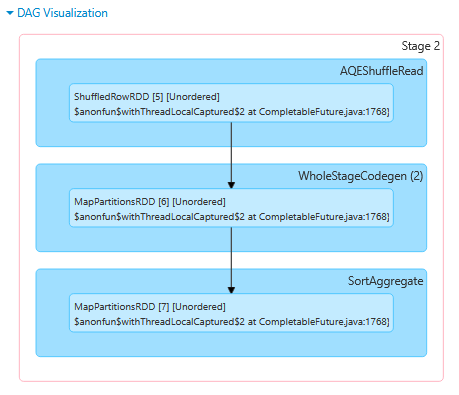

In [15]:
sc.stop()